## Import the packages

In [22]:
import pickle

import nltk
from nltk.corpus import wordnet
try:
    wordnet.synsets('noun')
except LookupError:
    nltk.download('wordnet')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

In [4]:
def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return set(synonyms)
print(get_synonyms('good'))

{'trade_good', 'sound', 'goodness', 'commodity', 'just', 'serious', 'beneficial', 'proficient', 'practiced', 'skillful', 'upright', 'adept', 'salutary', 'effective', 'estimable', 'dear', 'secure', 'near', 'unspoiled', 'full', 'in_effect', 'expert', 'undecomposed', 'unspoilt', 'soundly', 'well', 'skilful', 'right', 'good', 'honest', 'dependable', 'thoroughly', 'safe', 'respectable', 'in_force', 'honorable', 'ripe'}


## Load the dataset

In [10]:
train_data = pd.read_json('./data/tokenized_train.jsonl',lines = True)
train_table_json = pd.read_json('./data/tokenized_train.tables.jsonl', lines = True)

In [11]:
test_data = pd.read_json('./data/tokenized_test.jsonl',lines = True)
test_table_json = pd.read_json('./data/tokenized_test.tables.jsonl', lines = True)

In [12]:
train_table_dict = {}
for x in train_table_json.iterrows():
    td = x[1].to_dict()
    train_table_dict[td['id']] = td

In [13]:
train_sql_queries = train_data['sql'].to_list()
train_questions = train_data['question'].to_list()

In [14]:
agg_dict = {}
for i,x in enumerate(['', 'MAX', 'MIN', 'COUNT', 'SUM', 'AVG']):
    agg_dict[i] = x

In [15]:
for i,sql in enumerate(train_sql_queries):
    if(sql['agg']!=0 and sql['agg']!= 3):
        print(f"index {i}: - {agg_dict[sql['agg']]} | {train_questions[i]}" )

index 23: - MIN | What number is the player that played 1998-2001
index 43: - MAX | What time was the highest for 2nd finishers?
index 44: - MIN | When did the Metrostars have their first Rookie of the Year winner?
index 55: - MIN | What is year of construction of spitallamm?
index 64: - MAX | What is the number of chapters listed for the fraternity with a headquarters in Austin, Texas?
index 68: - MIN | what is the number of relapsing fever when malaria is 3000
index 71: - MAX | what is the number of smallpox when typhoid fever is 293
index 75: - MIN | In what year was Lindenwood University founded?
index 84: - MIN | what is the minimum population canada 2011 census with seat of rcm being cowansville
index 92: - MIN | What is the the Chinese population for the state that has a Filipino population of 1474707?
index 94: - MAX | What is the highest Indian population?
index 104: - MIN | How many wins happened in 1983?
index 106: - MAX | How many poles had an average finish of 19.1?
index 

In [16]:
print(train_data.iloc[71]['question'])
print(train_data.iloc[71]['query'])

what is the number of smallpox when typhoid fever is 293
SELECT max ( smallpox ) FROM table_ WHERE typhoid fever EQL 293


In [17]:
train_table_dict[train_data.iloc[71]['table_id']]

{'id': '1-1007688-1',
 'header': ['Year',
  'Typhus',
  'Typhoid fever',
  'Relapsing fever',
  'Smallpox',
  'Malaria'],
 'types': ['text', 'real', 'real', 'real', 'real', 'text'],
 'rows': [['1913', 120, 424, 30, 67, '3600'],
  ['1918–22', 1300, 293, 639, 106, '2940 (avg)'],
  ['1929', 40, 170, 6, 8, '3000'],
  ['1930', 60, 190, 5, 10, '2700'],
  ['1931', 80, 260, 4, 30, '3200'],
  ['1932', 220, 300, 12, 80, '4500'],
  ['1933', 800, 210, 12, 38, '6500'],
  ['1934', 410, 200, 10, 16, '9477'],
  ['1935', 120, 140, 6, 4, '9924']],
 'name': 'table_1007688_1',
 'page_title': 'Holodomor',
 'section_title': 'Death toll',
 'caption': 'Incidence of disease in Russian Empire and USSR',
 'page_id': nan,
 'tokenized_header': [['year'],
  ['typhus'],
  ['typhoid', 'fever'],
  ['relapsing', 'fever'],
  ['smallpox'],
  ['malaria']]}

## Training and testing dataset

In [18]:
train_question   = list(x[1]['question'] for x in train_data.iterrows())
train_aggregator = list(x[1]['sql']['agg'] for x in train_data.iterrows())

In [19]:
test_questions = list(x[1]['question'] for x in test_data.iterrows())
test_aggregator = list(x[1]['sql']['agg'] for x in test_data.iterrows())

## TF-IDF


In [20]:
vectorizer = TfidfVectorizer(max_features=30190)

#vectorizer = vectorizer.fit(question_list)
X_train = vectorizer.fit_transform(train_question)
Y_train = np.array(train_aggregator)
print(X_train.shape)

(56355, 30190)


In [21]:
X_test = vectorizer.transform(test_questions)
Y_test = np.array(test_aggregator)
print(X_test.shape, Y_test.shape)

(15878, 30190) (15878,)


## Resampling

### Seperate the class with less samples

In [16]:
print(type(Y_train))

<class 'numpy.ndarray'>


In [17]:
def get_small_class(X,Y:np.ndarray,threshold = 0.4, inplace = False):
    ret_value = np.array(0)
    unq_val, value_count = np.unique(Y,return_counts=  True)
    max_index, max_val = np.argmax(value_count,), np.max(value_count)
    percent_array = value_count/max_val
    lower_than_thresh = np.flatnonzero(percent_array < threshold).tolist()
    amount_to_multiply = np.floor(1 / np.array(list(percent_array[x] for x in lower_than_thresh)))
    print(amount_to_multiply)
    small_classes = [unq_val[x] for x in lower_than_thresh]
    
    for x in range(len(small_classes)):
        condition = np.in1d(Y,small_classes[x])
        
        #print(index_pos.shape)
    #print(small_classes)
#np.in1d?
get_small_class(X_train,Y_train)

[12. 12.  7. 19. 18.]


### Just use Imbalace-learn

In [19]:
ros = RandomOverSampler (random_state = 45)
X_res,Y_res = ros.fit_resample(X_train,Y_train)

In [20]:
print(X_res.shape,Y_res.shape)

(243636, 30190) (243636,)


In [21]:
#Y = np.array(y,)
x_label, y_label = np.unique(Y_res,return_counts=True)

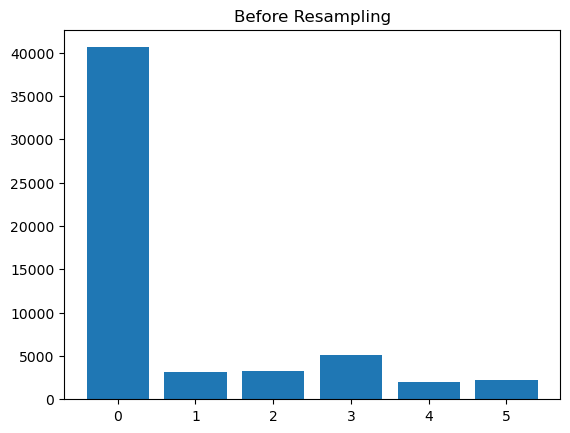

In [23]:
plt.title("Before Resampling")
plt.bar(x_label,np.unique(Y_train,return_counts=True)[1])
plt.show()

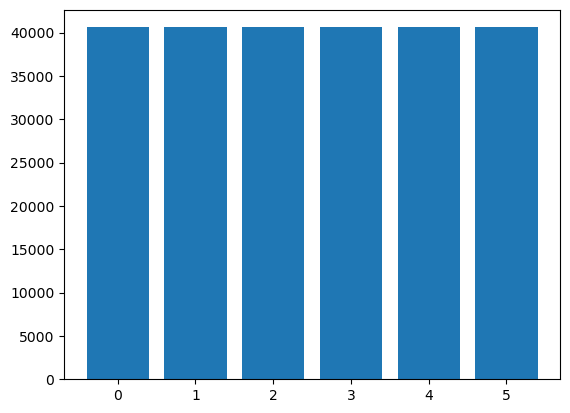

In [24]:
plt.bar(x_label,y_label)
plt.show()

## Undersampling

### Random UnderSampler

In [17]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=45)
X_res,Y_res = rus.fit_resample(X_train,Y_train)
print(X_res.shape,Y_res.shape)

(17791, 30190) (17791,)


In [18]:
x_label, y_label = np.unique(Y_res,return_counts=True)

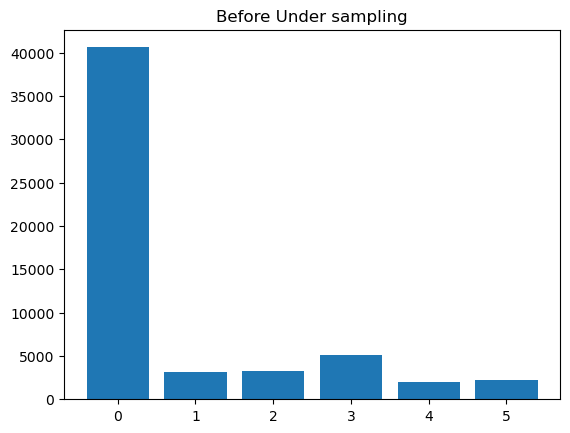

In [21]:
plt.title("Before Under sampling")
plt.bar(x_label,np.unique(Y_train,return_counts=True)[1])
plt.show()

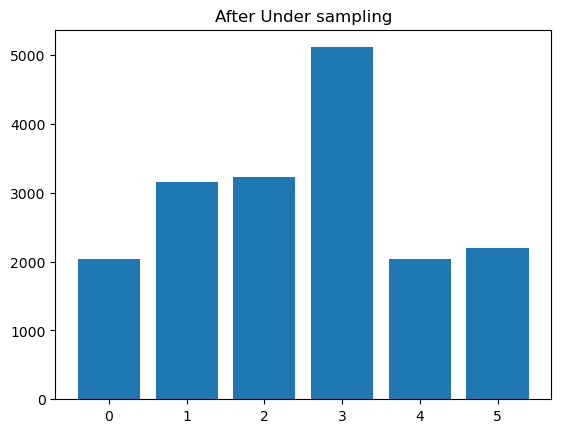

In [22]:
plt.title("After Under sampling")
plt.bar(x_label,np.unique(Y_res,return_counts=True)[1])
plt.show()

### Clustering UnderSampler

In [67]:
cc = ClusterCentroids(sampling_strategy='majority',random_state=32,)
X_res, Y_res = cc.fit_resample(X_train,Y_train)
print(X_res.shape, Y_res.shape)

/home/user/enter/envs/ml/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(17791, 30190) (17791,)


In [68]:
x_label, y_label = np.unique(Y_res,return_counts=True)

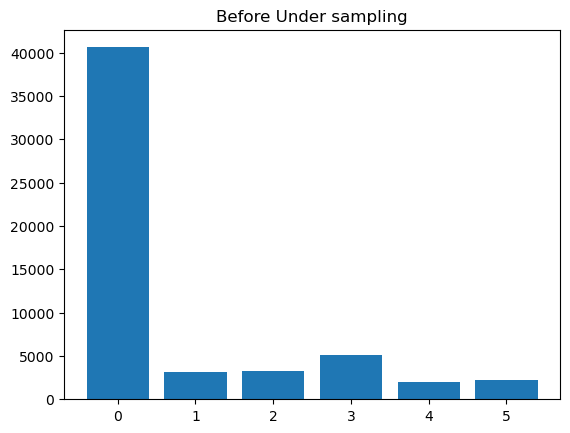

In [69]:
plt.title("Before Under sampling")
plt.bar(x_label,np.unique(Y_train,return_counts=True)[1])
plt.show()

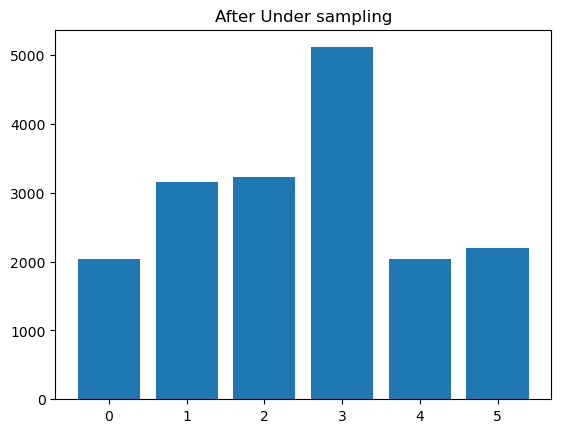

In [70]:
plt.title("After Under sampling")
plt.bar(x_label,np.unique(Y_res,return_counts=True)[1])
plt.show()

## MultinomialNB

In [53]:
from sklearn.naive_bayes import MultinomialNB

In [54]:
classifier = MultinomialNB()
classifier.fit(X_res,Y_res)

MultinomialNB()

In [55]:
y_pred = classifier.predict(X_train)

In [56]:
from sklearn.metrics import accuracy_score, classification_report

In [57]:
report = classification_report(Y_train, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.06      0.11     40606
           1       0.61      0.74      0.67      3161
           2       0.64      0.79      0.70      3231
           3       0.11      0.99      0.20      5114
           4       0.96      0.08      0.15      2042
           5       0.91      0.29      0.44      2201

    accuracy                           0.23     56355
   macro avg       0.70      0.49      0.38     56355
weighted avg       0.87      0.23      0.20     56355



In [58]:
y_pred = classifier.predict(X_test)
report = classification_report(Y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.05      0.10     11324
           1       0.59      0.65      0.62       973
           2       0.56      0.70      0.62       933
           3       0.11      0.97      0.20      1455
           4       1.00      0.05      0.09       587
           5       0.85      0.13      0.23       606

    accuracy                           0.21     15878
   macro avg       0.68      0.43      0.31     15878
weighted avg       0.86      0.21      0.18     15878



## SVM

In [60]:
svc = SVC(verbose = True)

In [61]:
svc.fit(X_res,Y_res)

[LibSVM]...*.*
optimization finished, #iter = 4360
obj = -1163.278242, rho = -0.143249
nSV = 3097, nBSV = 895
...*.*
optimization finished, #iter = 4399
obj = -1124.703185, rho = -0.161762
nSV = 3070, nBSV = 833
...*.*
optimization finished, #iter = 4922
obj = -1218.147115, rho = -0.131253
nSV = 3387, nBSV = 857
..*.*
optimization finished, #iter = 3869
obj = -905.527931, rho = -0.487050
nSV = 2575, nBSV = 592
..*.*
optimization finished, #iter = 3573
obj = -781.786987, rho = -0.552634
nSV = 2413, nBSV = 535
...*.*
optimization finished, #iter = 4382
obj = -1377.658360, rho = -0.054494
nSV = 3530, nBSV = 1414
....*..*
optimization finished, #iter = 6423
obj = -1534.550224, rho = 0.191154
nSV = 4513, nBSV = 1231
..*.*
optimization finished, #iter = 3768
obj = -1265.240850, rho = -0.356629
nSV = 2928, nBSV = 1194
..*.*
optimization finished, #iter = 3504
obj = -1072.848747, rho = -0.451299
nSV = 2665, nBSV = 980
....*..*
optimization finished, #iter = 6087
obj = -1405.288970, rho = 0.164

SVC(verbose=True)

In [62]:
y_pred =svc.predict(X_train)


In [63]:
report = classification_report(Y_train, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     40606
           1       0.77      0.91      0.84      3161
           2       0.85      0.92      0.88      3231
           3       0.54      0.97      0.69      5114
           4       0.61      0.79      0.68      2042
           5       0.70      0.90      0.79      2201

    accuracy                           0.86     56355
   macro avg       0.74      0.89      0.80     56355
weighted avg       0.91      0.86      0.87     56355



In [64]:
y_pred =svc.predict(X_test)
report = classification_report(Y_test,y_pred)

In [65]:
print(report)

              precision    recall  f1-score   support

           0       0.97      0.83      0.89     11324
           1       0.71      0.74      0.73       973
           2       0.77      0.77      0.77       933
           3       0.45      0.87      0.60      1455
           4       0.39      0.41      0.40       587
           5       0.55      0.70      0.62       606

    accuracy                           0.81     15878
   macro avg       0.64      0.72      0.67     15878
weighted avg       0.85      0.81      0.82     15878



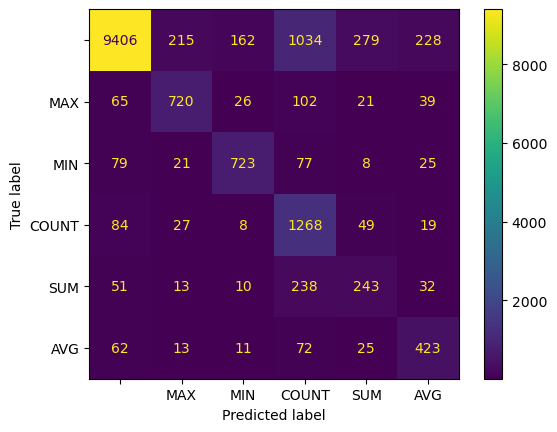

In [66]:
cmatrix = confusion_matrix(Y_test,y_pred,)
cd = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=list(agg_dict.values()))
cd.plot()
plt.show()

In [44]:

# with open('./trained_models/AggregatorPredictor_Undersampled_SVM_Default_parameters.pkl',"wb") as f:
#     pickle.dump(svc, f)

In [45]:
# svb = SVC()
# with open('./trained_models/AggregatorPredictor_Undersampled_SVM_Default_parameters.pkl',"rb") as f:
#     svb = pickle.load(f)

In [46]:
y_pred =svb.predict(X_test)
report = classification_report(Y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     11324
           1       0.72      0.74      0.73       973
           2       0.76      0.78      0.77       933
           3       0.47      0.87      0.61      1455
           4       0.41      0.41      0.41       587
           5       0.55      0.70      0.61       606

    accuracy                           0.81     15878
   macro avg       0.64      0.72      0.67     15878
weighted avg       0.86      0.81      0.82     15878



In [47]:
print(svb.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': True}


## Perform Grid Search

In [33]:
# create the parameters to search
C = np.arange(0.01,2.0,0.1, dtype=np.float32)
kernel = ['linear', 'sigmoid', 'rbf','poly']
decision_function_shape = ['ovo','ovr']
shrinking = [True, False]

args = []
for x in kernel:
    arg_dict = {}
    arg_dict['kernel'] = [x]
    arg_dict['C'] = C
    arg_dict['decision_function_shape'] = decision_function_shape
    arg_dict['shrinking'] = shrinking
    if x == 'poly':
        arg_dict['degree'] = list(range(2,8))
    args.append(arg_dict)

In [34]:
svm_arg = args[-1]
svm = SVC(C=svm_arg['C'][0], 
          kernel=svm_arg['kernel'], 
          decision_function_shape=svm_arg['decision_function_shape'][0], 
          degree=svm_arg['degree'][0],
        )

In [37]:
grid_search = GridSearchCV(estimator=svm, 
                           scoring=['accuracy','average_precision'],
                           param_grid=args,
                           n_jobs=-1,
                           verbose = 3,)

In [36]:
grid_search.fit(X_res,Y_res)
y_pred = grid_search.predict(X_test)
report = classification_report(Y_test,y_pred)


Fitting 5 folds for each of 720 candidates, totalling 3600 fits


KeyboardInterrupt: 

In [ ]:

cmatrix = confusion_matrix(Y_test,y_pred,)
cd = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=list(agg_dict.values()))
cd.plot()
plt.show()

## Inferences and testing

In [33]:
# Load the grid search model
#grid_search = GridSearchCV()
with open('./trained_models/aggregator/Grid_Search_ob.pkl','rb') as f:
    grid_search = pickle.load(f)

/home/user/enter/envs/ml/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.1.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_127/3082035931.py:4: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  grid_search = pickle.load(f)
/home/user/enter/envs/ml/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.1.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [34]:
grid_search

GridSearchCV(estimator=SVC(C=0.01, decision_function_shape='ovo', degree=2,
                           kernel=['poly']),
             n_jobs=32,
             param_grid=[{'C': array([0.01      , 0.11      , 0.21000001, 0.31      , 0.41      ,
       0.51      , 0.61      , 0.71      , 0.81      , 0.91      ,
       1.01      , 1.11      , 1.21      , 1.3100001 , 1.41      ,
       1.51      , 1.61      , 1.71      , 1.8100001 , 1.91      ],
      dtype=float32),
                          'decision_function_shape': ['ovo', 'ovr'],
                          'kernel': ['linear'], 'shrinking': [True, False]},
                         {'C': arr...
                          'decision_function_shape': ['ovo', 'ovr'],
                          'kernel': ['rbf'], 'shrinking': [True, False]},
                         {'C': array([0.01      , 0.11      , 0.21000001, 0.31      , 0.41      ,
       0.51      , 0.61      , 0.71      , 0.81      , 0.91      ,
       1.01      , 1.11      , 1.21      , 1.3100001 , 1.41      ,
       1.51      , 1.61      , 1.71      , 1.8100001 , 1.91      ],
      dtype=float32),
                          'decision_function_shape': ['ovo', 'ovr'],
                          'degree': [2, 3, 4, 5, 6, 7], 'kernel': ['poly'],
                          'shrinking': [True, False]}],
             scoring='accuracy', verbose=3)

In [36]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_decision_function_shape', 'param_kernel', 'param_shrinking', 'param_degree', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [44]:
grid_search.best_params_

{'C': 0.91,
 'decision_function_shape': 'ovo',
 'kernel': 'rbf',
 'shrinking': True}

In [52]:
gridSearchDF = pd.DataFrame(grid_search.cv_results_)
gridSearchDF.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_decision_function_shape,param_kernel,param_shrinking,param_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,36.502288,0.693558,5.911815,0.208635,0.01,ovo,linear,True,NaN,"{'C': 0.01, 'decision_function_shape': 'ovo', ...",0.349255,0.415683,0.432265,0.493536,0.487352,0.435618,0.052722,405
1,35.204441,0.887207,5.793929,0.160595,0.01,ovo,linear,False,NaN,"{'C': 0.01, 'decision_function_shape': 'ovo', ...",0.349255,0.415683,0.432265,0.493536,0.487352,0.435618,0.052722,405
2,36.367448,0.749036,5.871351,0.198919,0.01,ovr,linear,True,NaN,"{'C': 0.01, 'decision_function_shape': 'ovr', ...",0.349255,0.415683,0.432265,0.493536,0.487352,0.435618,0.052722,405
3,35.445146,0.827096,5.833912,0.211055,0.01,ovr,linear,False,NaN,"{'C': 0.01, 'decision_function_shape': 'ovr', ...",0.349255,0.415683,0.432265,0.493536,0.487352,0.435618,0.052722,405
4,25.363723,0.974165,4.659397,0.190147,0.11,ovo,linear,True,NaN,"{'C': 0.11, 'decision_function_shape': 'ovo', ...",0.639786,0.733558,0.775155,0.697583,0.712760,0.711768,0.044444,193


In [60]:
gridSearchDF[gridSearchDF['param_kernel'] == 'linear'and gridSearchDF['param_decision_function_shape'] == 'ovo']

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [72]:
def GetAggregator(text):
    sent_vec = vectorizer.transform([text])
    svc = grid_search.best_estimator_
    agg = svc.predict(sent_vec)[0]
    print(agg_dict[agg])
text = "Number of Children are there in the park?"
GetAggregator(text)

COUNT
